In [1]:
import numpy as np
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [4]:
# import dataset
train_df = pd.read_csv("/content/drive/MyDrive/Hackathon/HEARTBEAT DATASET/mitbih_train.csv", header = None)
test_df = pd.read_csv("/content/drive/MyDrive/Hackathon/HEARTBEAT DATASET/mitbih_test.csv", header = None)

In [5]:
# Value of each class
train_df[187].value_counts()

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64

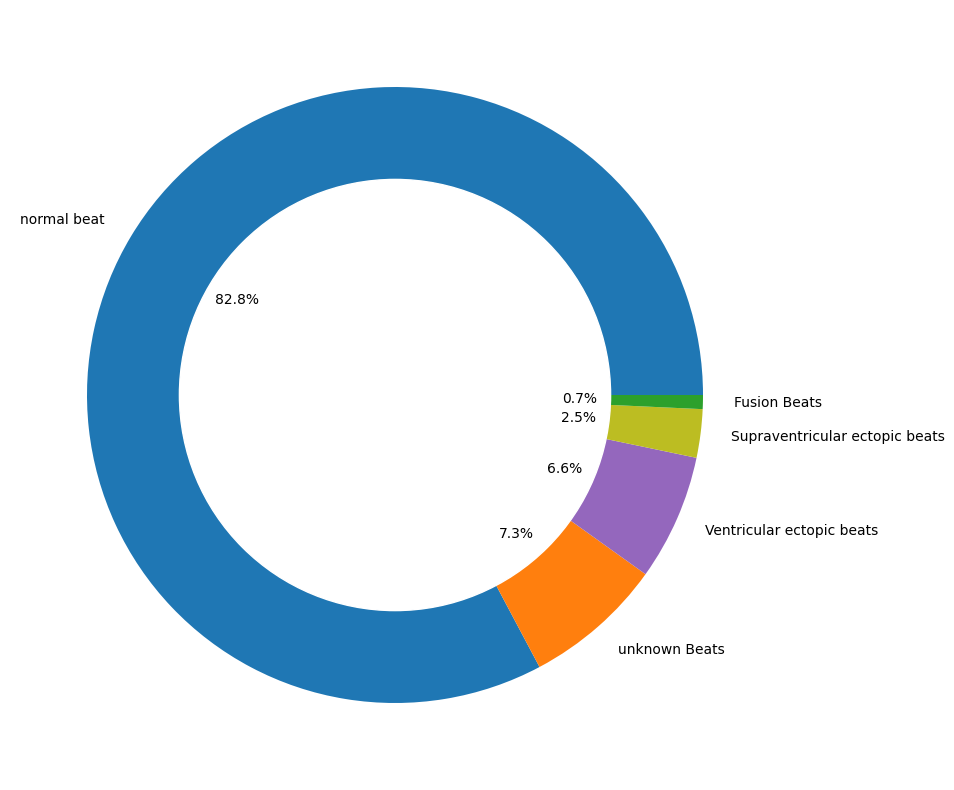

In [6]:
# representation of classes % wise
per_class = train_df[187].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat','unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats','Fusion Beats'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

## Resampling for balacing the dataset

In [7]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

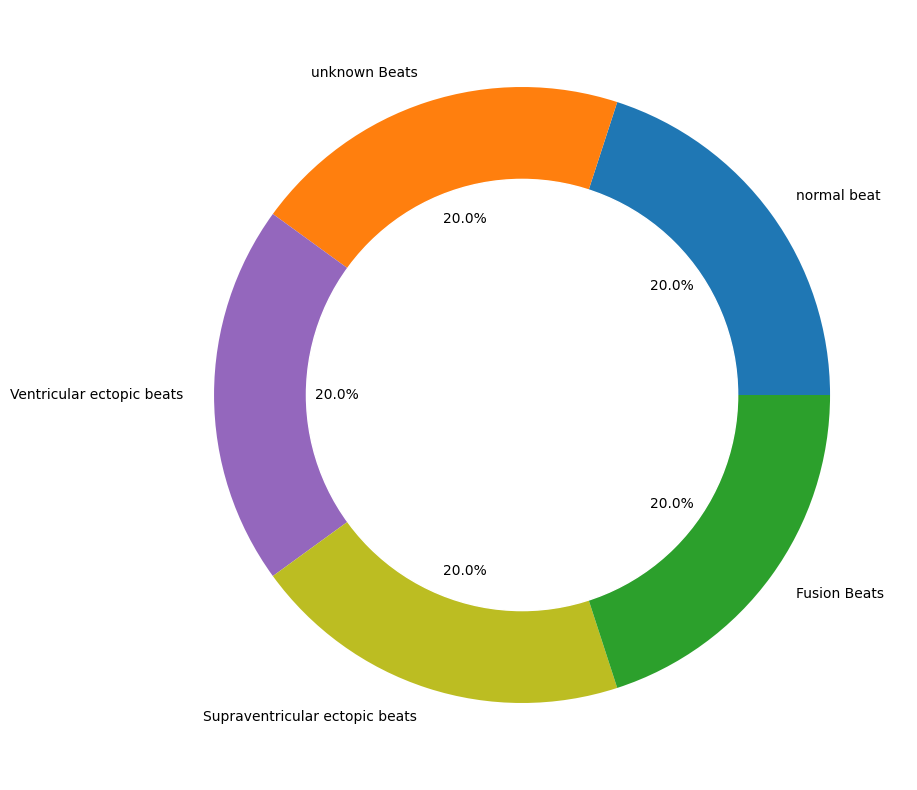

In [8]:
# representation of classes % wise
per_class = train_df[187].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat','unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats','Fusion Beats'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

## Classes

In [9]:
# randomly sampling from each class
classes=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))

In [10]:
# peek on classes
classes

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
17076,1.000000,0.656410,0.074359,0.069231,0.120513,0.094872,0.115385,0.102564,0.102564,0.094872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73397,1.000000,0.722910,0.312694,0.154799,0.061920,0.041796,0.012384,0.046440,0.117647,0.267802,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
76449,0.000000,0.013536,0.055838,0.167513,0.206430,0.289340,0.348562,0.407783,0.456853,0.478849,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
81088,1.000000,0.789400,0.500697,0.188285,0.040446,0.080893,0.078103,0.047420,0.039052,0.023710,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
85052,0.709677,0.661290,0.580645,0.580645,0.540323,0.524194,0.471774,0.423387,0.338710,0.197581,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


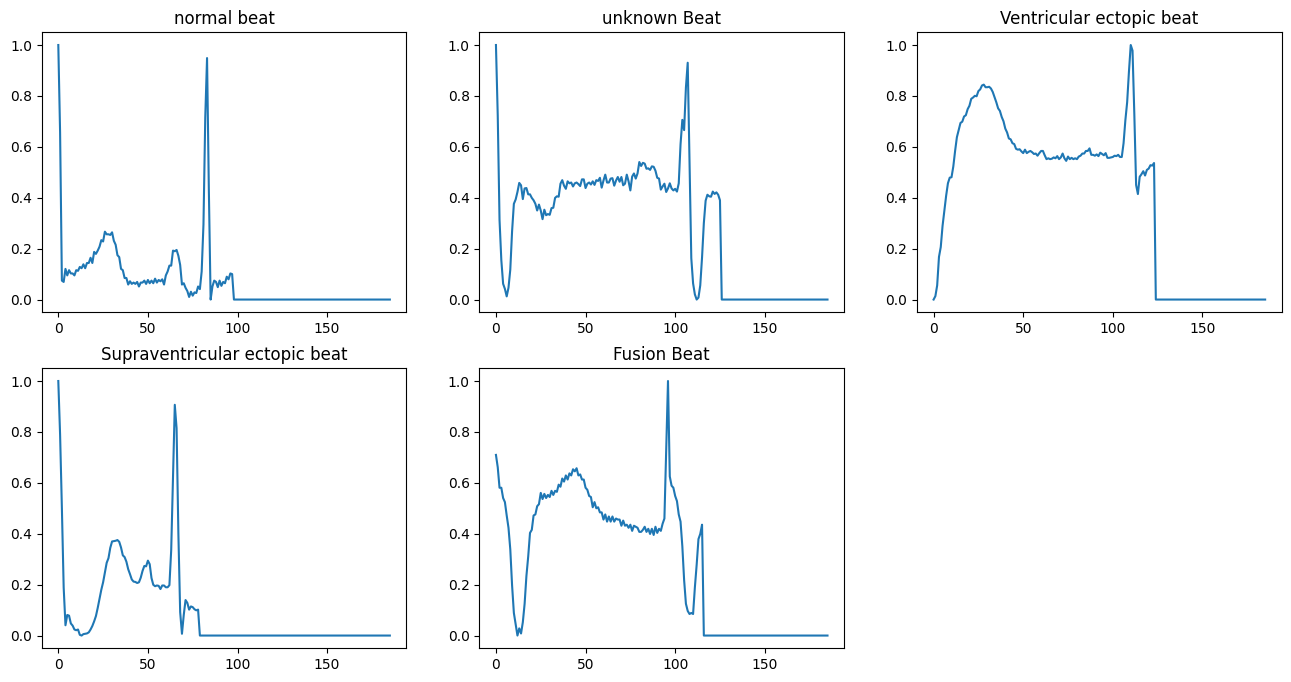

In [11]:
# plotting classes ECG
plt.figure(figsize=(16,8))
# normal
plt.subplot(2, 3, 1)
plt.plot(classes.iloc[0,:186])
plt.title('normal beat')
# unknown
plt.subplot(2, 3, 2)
plt.plot(classes.iloc[1,:186])
plt.title('unknown Beat')
# veb
plt.subplot(2, 3, 3)
plt.plot(classes.iloc[2,:186])
plt.title('Ventricular ectopic beat')
# seb
plt.subplot(2, 3, 4)
plt.plot(classes.iloc[3,:186])
plt.title('Supraventricular ectopic beat')
# fusion
plt.subplot(2, 3, 5)
plt.plot(classes.iloc[4,:186])
plt.title('Fusion Beat')
# show plot
plt.show()

## Signal heatmap

In [12]:
def plot_hist(class_number,size,min_):
    # get the class data
    img=train_df.loc[train_df[187]==class_number].values
    # crop it
    img=img[:,min_:size]
    # creates a continous steam of data
    img_flatten=img.flatten()

    final1=np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1=np.arange(min_,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(80,80),cmap=plt.cm.jet)
    plt.show()

1300000
1300000


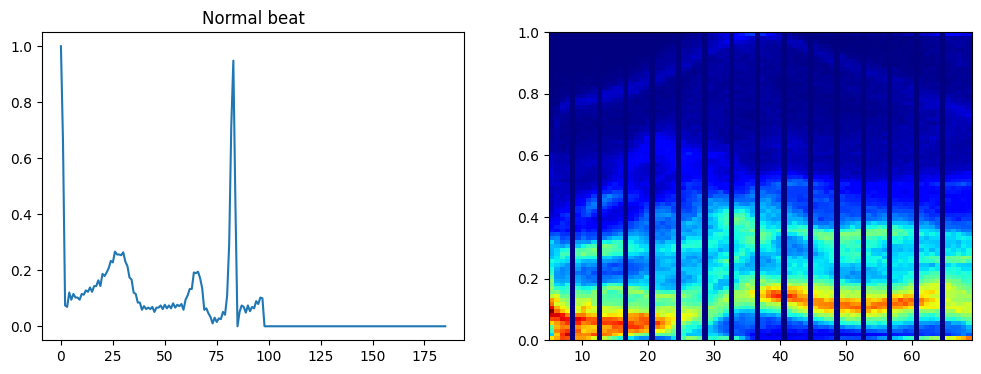

In [13]:
# Normal Beat
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(classes.iloc[0,:186])
plt.title('Normal beat')
plt.subplot(1, 2, 2)
plot_hist(0,70,5)

900000
900000


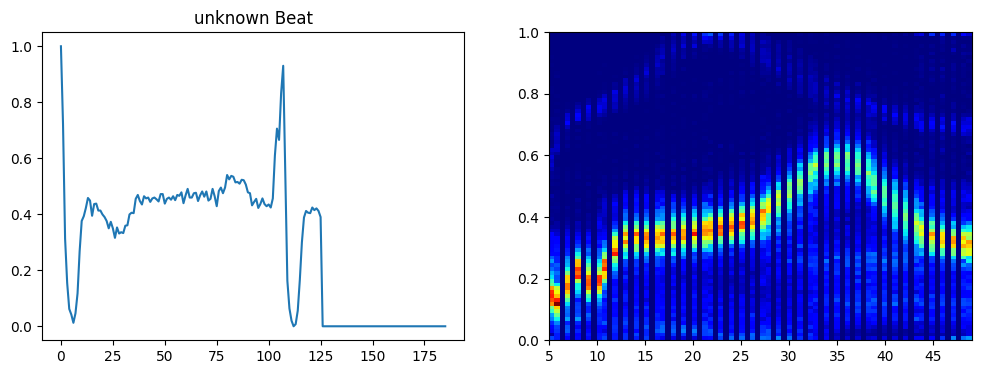

In [14]:
# unknown
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(classes.iloc[1,:186])
plt.title('unknown Beat')
plt.subplot(1, 2, 2)
plot_hist(1,50,5)

600000
600000


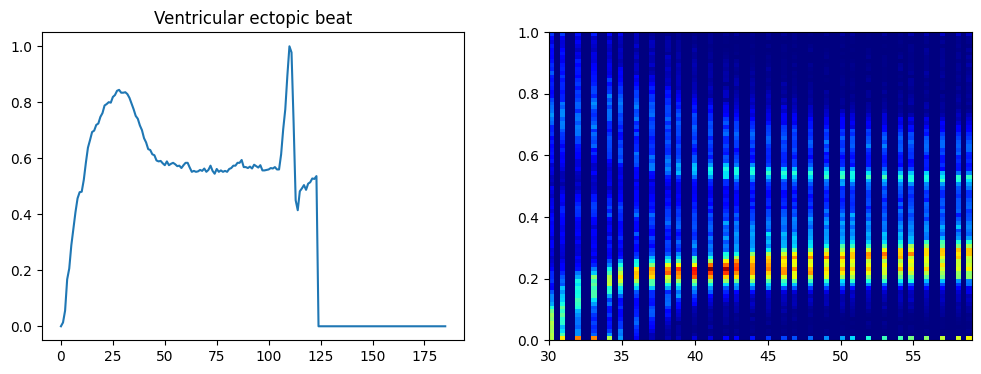

In [15]:
# veb
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(classes.iloc[2,:186])
plt.title('Ventricular ectopic beat')
plt.subplot(1, 2, 2)
plot_hist(2,60,30)

700000
700000


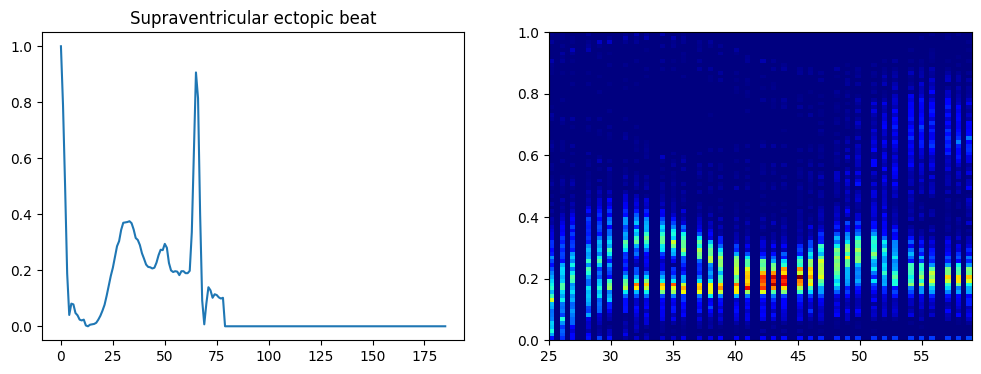

In [16]:
# seb
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(classes.iloc[3,:186])
plt.title('Supraventricular ectopic beat')
plt.subplot(1, 2, 2)
plot_hist(3,60,25)

640000
640000


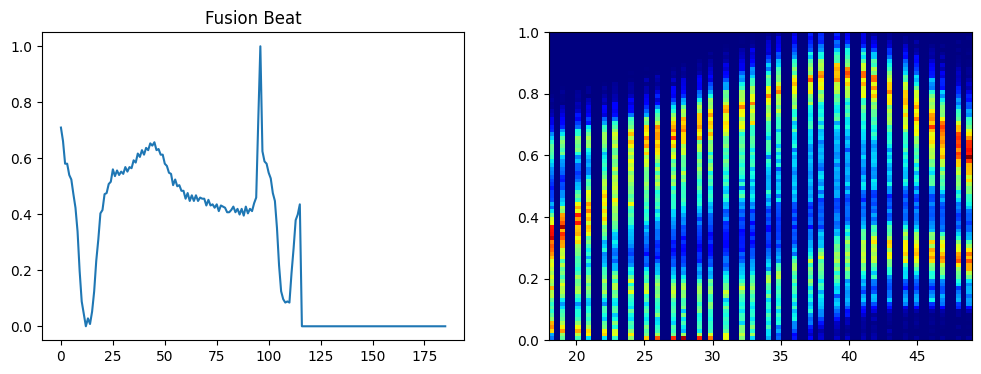

In [17]:
# fusion
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(classes.iloc[4,:186])
plt.title('Fusion Beat')
plt.subplot(1, 2, 2)
plot_hist(4,50,18)

## Pretreat

In [18]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.05,186)
    return (signal+noise)

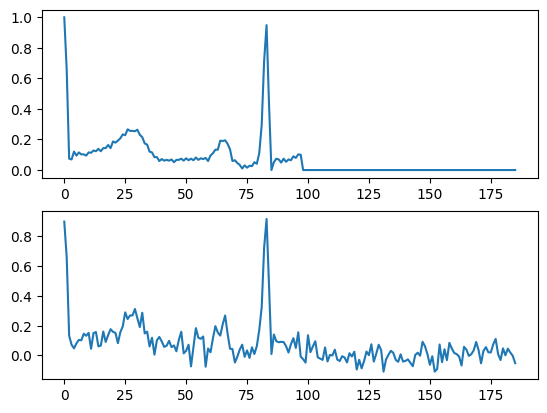

In [19]:
tempo=classes.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(classes.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()

In [20]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [21]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
#for i in range(len(X_train)):
#    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [22]:
# Network
def network(X_train,y_train,X_test,y_test):
    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)


    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])


    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=5,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [23]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']

    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [24]:
import keras
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test)

Epoch 1/5
3125/3125 [==============================] - 122s 38ms/step - loss: 0.1967 - accuracy: 0.9296 - val_loss: 0.2106 - val_accuracy: 0.9376
Epoch 2/5
3125/3125 [==============================] - 127s 41ms/step - loss: 0.0741 - accuracy: 0.9753 - val_loss: 0.1403 - val_accuracy: 0.9564
Epoch 3/5
3125/3125 [==============================] - 108s 35ms/step - loss: 0.0500 - accuracy: 0.9831 - val_loss: 0.1539 - val_accuracy: 0.9557
Epoch 4/5
3125/3125 [==============================] - 111s 35ms/step - loss: 0.0376 - accuracy: 0.9875 - val_loss: 0.1344 - val_accuracy: 0.9625
Epoch 5/5
3125/3125 [==============================] - 109s 35ms/step - loss: 0.0296 - accuracy: 0.9902 - val_loss: 0.1188 - val_accuracy: 0.9730


Accuracy: 97.30%


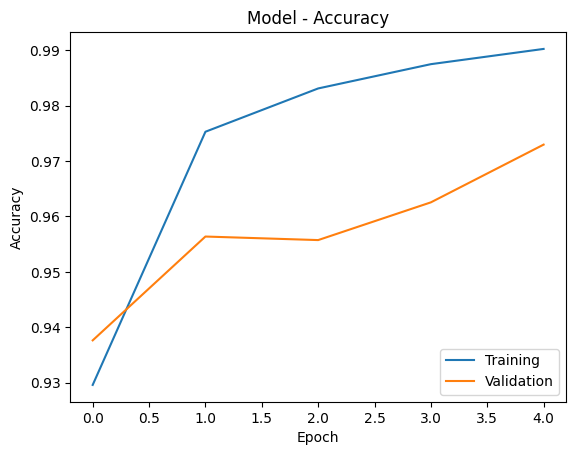

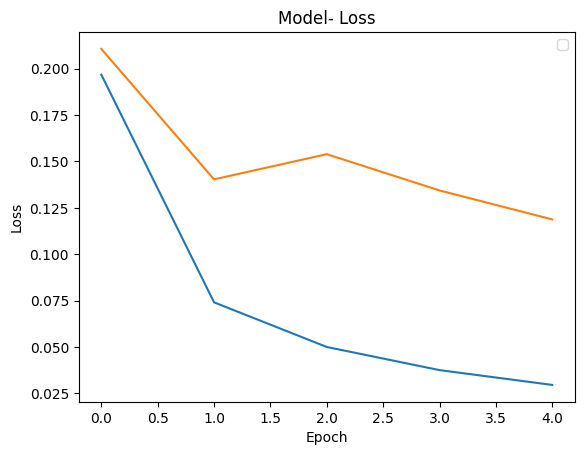

685/685 [==============================] - 5s 8ms/step


In [25]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [27]:

encoder = preprocessing.LabelEncoder()
encoder.fit(target_train)
Y_train = encoder.transform(target_train)
encoder.fit(target_test)
Y_test = encoder.transform(target_test)

In [28]:
nsamples, nx, ny = X_train.shape
train_dataset = X_train.reshape((nsamples,nx*ny))
nsamples, nx, ny = X_test.shape
test_dataset = X_test.reshape((nsamples,nx*ny))


In [29]:
accu = []
prec = []
recc = []
f1   = []
models =[]

In [30]:
ytest = Y_test

<h1> DecisionTree<\h1>


In [31]:

dtree_model = DecisionTreeClassifier(max_depth = 100).fit(train_dataset, Y_train)
dt_pred = dtree_model.predict(test_dataset)

# creating a confusion matrix
#cm = confusion_matrix(Y_test, dtree_predictions)


accuracy_score(Y_test, dt_pred)#, normalize=False)

0.9294719532249224

In [32]:
print('Accuracy Score : ' + str(accuracy_score(ytest, dt_pred)))
print('Precision Score : ' + str(precision_score(ytest,dt_pred,average='macro')))
print('Recall Score : ' + str(recall_score(ytest,dt_pred,average='macro')))
print('F1 Score : ' + str(f1_score(ytest,dt_pred,average='macro')))

# Classifier Confusion matrix

print('Confusion Matrix : \n' + str(confusion_matrix(ytest,dt_pred)))


accu.append(accuracy_score(ytest, dt_pred))
prec.append(precision_score(ytest,dt_pred,average='macro'))
recc.append(recall_score(ytest,dt_pred,average='macro'))
f1.append(f1_score(ytest,dt_pred,average='macro'))
models.append("Decision Tree" )

Accuracy Score : 0.9294719532249224
Precision Score : 0.7104413396008608
Recall Score : 0.8318813853743103
F1 Score : 0.7611217761718694
Confusion Matrix : 
[[17059   429   340    88   202]
 [  135   389    17     4    11]
 [  112    12  1273    29    22]
 [   28     0    19   113     2]
 [   64    11    18     1  1514]]


<h1>Logistic Regression<\h1>

In [33]:
clf = LogisticRegression(random_state=0).fit(train_dataset, Y_train)
lr_pred = clf.predict(test_dataset)



In [34]:
print('Accuracy Score : ' + str(accuracy_score(ytest, lr_pred)))
print('Precision Score : ' + str(precision_score(ytest,lr_pred,average='macro')))
print('Recall Score : ' + str(recall_score(ytest,lr_pred,average='macro')))
print('F1 Score : ' + str(f1_score(ytest,lr_pred,average='macro')))

# Classifier Confusion matrix

print('Confusion Matrix : \n' + str(confusion_matrix(ytest,lr_pred)))



accu.append(accuracy_score(ytest, lr_pred))
prec.append(precision_score(ytest,lr_pred,average='macro'))
recc.append(recall_score(ytest,lr_pred,average='macro'))
f1.append(f1_score(ytest,lr_pred,average='macro'))
models.append("Logistic Regression" )

Accuracy Score : 0.6590535355380961
Precision Score : 0.4419793342217103
Recall Score : 0.7614725454163797
F1 Score : 0.47205550296043686
Confusion Matrix : 
[[11405  2318  2473  1452   470]
 [  127   372    30    21     6]
 [  144    49  1047   158    50]
 [    9     0    11   142     0]
 [   54     5    79     8  1462]]


# Gaussian naive_bayes

In [35]:
gnb = GaussianNB()
nb_pred = gnb.fit(train_dataset, Y_train).predict(test_dataset)


accuracy_score(ytest,nb_pred)

0.18888178329983554

In [36]:
print('Accuracy Score : ' + str(accuracy_score(ytest, nb_pred)))
print('Precision Score : ' + str(precision_score(ytest,nb_pred,average='macro')))
print('Recall Score : ' + str(recall_score(ytest,nb_pred,average='macro')))
print('F1 Score : ' + str(f1_score(ytest,nb_pred,average='macro')))

#Dummy Classifier Confusion matrix

print('Confusion Matrix : \n' + str(confusion_matrix(ytest,nb_pred)))

Accuracy Score : 0.18888178329983554
Precision Score : 0.33573706699674966
Recall Score : 0.45874728202303494
F1 Score : 0.177890660826155
Confusion Matrix : 
[[ 2041   108  1165  2497 12307]
 [   37    79    39    55   346]
 [  118     9   289    89   943]
 [    0     0     1   138    23]
 [    1     0     5    14  1588]]


In [37]:
accu.append(accuracy_score(ytest, nb_pred))
prec.append(precision_score(ytest,nb_pred,average='macro'))
recc.append(recall_score(ytest,nb_pred,average='macro'))
f1.append(f1_score(ytest,nb_pred,average='macro'))
models.append("Gaussian naive_bayes" )

# Random forrest

In [38]:
RF = RandomForestClassifier().fit(train_dataset, Y_train)
rf_pred = RF.predict(test_dataset)

In [39]:
print('Accuracy Score : ' + str(accuracy_score(ytest, rf_pred)))
print('Precision Score : ' + str(precision_score(ytest,rf_pred,average='macro')))
print('Recall Score : ' + str(recall_score(ytest,rf_pred,average='macro')))
print('F1 Score : ' + str(f1_score(ytest,rf_pred,average='macro')))

#Dummy Classifier Confusion matrix

print('Confusion Matrix : \n' + str(confusion_matrix(ytest,rf_pred)))

Accuracy Score : 0.976475424812717
Precision Score : 0.9085324071846748
Recall Score : 0.8710076495576324
F1 Score : 0.8888559349432874
Confusion Matrix : 
[[17947    81    57    12    21]
 [  142   411     1     1     1]
 [   73     2  1350    16     7]
 [   28     0    16   118     0]
 [   50     1     6     0  1551]]


In [40]:
accu.append(accuracy_score(ytest, rf_pred))
prec.append(precision_score(ytest,rf_pred,average='macro'))
recc.append(recall_score(ytest,rf_pred,average='macro'))
f1.append(f1_score(ytest,rf_pred,average='macro'))
models.append("Random forrest" )

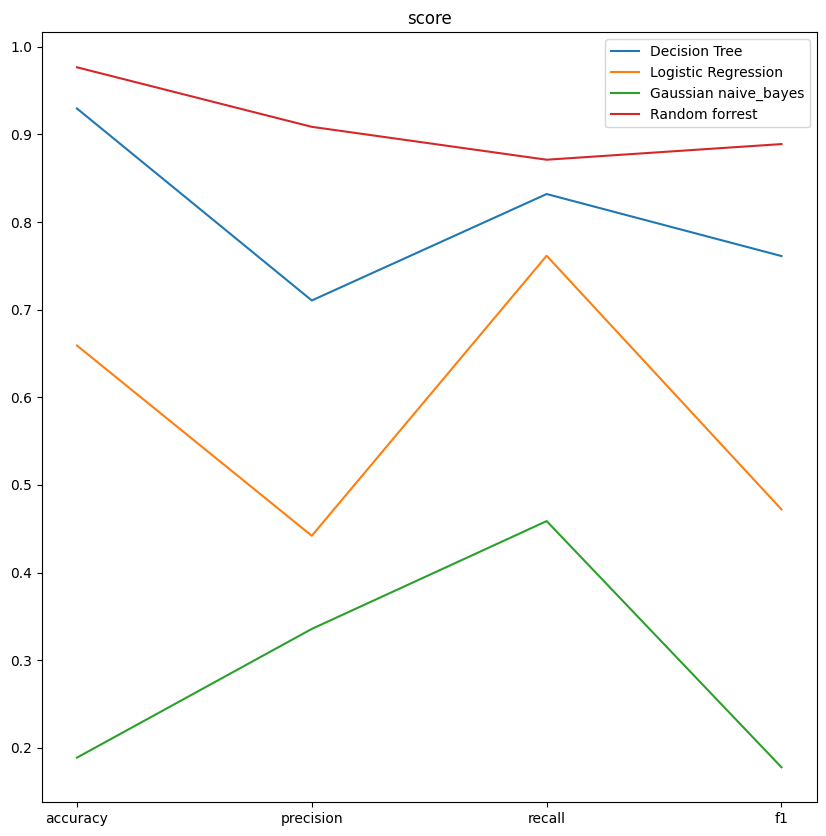

In [41]:
# create data
#x = [1,2,3,4]
x = ['accuracy','precision','recall','f1']
plt.figure(figsize=(10,10))
plt.title('score')
# plot lines
for i in range(len(accu)):
    plt.plot(x,[accu[i],prec[i],recc[i],f1[i]], label = models[i])
plt.legend()
plt.savefig('curves.png')
plt.show()